<div class="alert alert-block alert-success">
    <b><center>Pytorch LIBRARY</center></b>
    <b><center>MNIST CNN</center></b>
</div>

# Configure Learning Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Prepare Data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
res_train = datasets.MNIST("./datas", train=True, transform=transform, download=True)
res_valid = datasets.MNIST("./datas", train=False, transform=transform, download=True)

In [5]:
load_train = torch.utils.data.DataLoader(res_train, batch_size=100, shuffle=True)
load_valid = torch.utils.data.DataLoader(res_valid, batch_size=100, shuffle=True)

In [6]:
iter_train = iter(load_train)
images, labels = iter_train.next()
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [7]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 255)
    return image

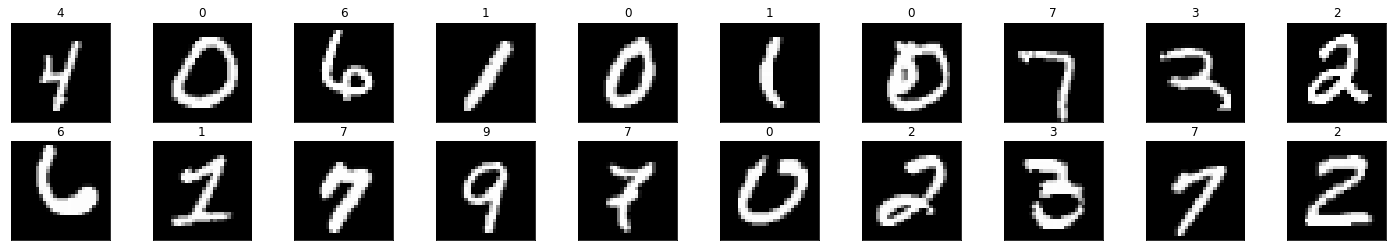

In [8]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

# Generate Model

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.act3 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 4*4*50)
        x = self.act3(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        return x

In [10]:
model = Classifier().to(device)
model

Classifier(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (act3): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [11]:
fn_loss = nn.CrossEntropyLoss()
fn_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training

In [12]:
epochs = 20
size_bunch_train = len(load_train)
size_bunch_valid = len(load_valid)

In [13]:
history = []
for epoch in range(epochs):
    loss_learns, accu_learns, loss_valids, accu_valids = .0, .0, .0, .0

    # Learning Step
    for datas, labels in load_train:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # backpropagation
        fn_optimizer.zero_grad()
        loss.backward()
        fn_optimizer.step()
        
        # Caculating loss/accuracy for monitoring
        loss_learns += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_learns += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    # Validating Step
    for datas, labels in load_valid:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # Caculating loss/accuracy for monitoring
        loss_valids += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_valids += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    loss_learn = loss_learns / size_bunch_train
    accu_learn = accu_learns / size_bunch_train
    loss_valid = loss_valids / size_bunch_valid
    accu_valid = accu_valids / size_bunch_valid
    history.append({"loss": loss_learn, "accuracy": accu_learn, "validation loss": loss_valid, "validation accuracy": accu_valid})
    
    print(f"{epoch+1:02d} step -> loss: {loss_learn:.4f}, accuracy: {accu_learn:.2f} %, validation loss: {loss_valid:.4f}, validation accuracy: {accu_valid:.2f} %")

01 step -> loss: 0.5544, accuracy: 85.09 %, validation loss: 0.1796, validation accuracy: 94.64 %
02 step -> loss: 0.1477, accuracy: 95.61 %, validation loss: 0.1033, validation accuracy: 97.03 %
03 step -> loss: 0.0984, accuracy: 97.00 %, validation loss: 0.0772, validation accuracy: 97.73 %
04 step -> loss: 0.0768, accuracy: 97.72 %, validation loss: 0.0600, validation accuracy: 98.06 %
05 step -> loss: 0.0637, accuracy: 98.08 %, validation loss: 0.0556, validation accuracy: 98.26 %
06 step -> loss: 0.0551, accuracy: 98.30 %, validation loss: 0.0497, validation accuracy: 98.44 %
07 step -> loss: 0.0482, accuracy: 98.54 %, validation loss: 0.0414, validation accuracy: 98.72 %
08 step -> loss: 0.0437, accuracy: 98.70 %, validation loss: 0.0425, validation accuracy: 98.78 %
09 step -> loss: 0.0393, accuracy: 98.82 %, validation loss: 0.0354, validation accuracy: 98.88 %
10 step -> loss: 0.0362, accuracy: 98.86 %, validation loss: 0.0387, validation accuracy: 98.76 %
11 step -> loss: 0.0

In [14]:
df_history = pd.DataFrame.from_records(history)

<AxesSubplot:>

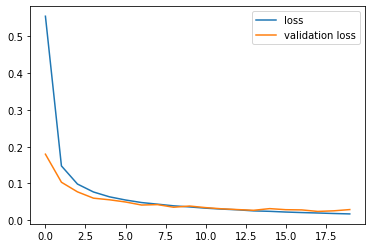

In [15]:
df_history[["loss", "validation loss"]].plot()

<AxesSubplot:>

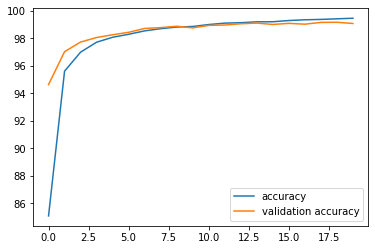

In [16]:
df_history[["accuracy", "validation accuracy"]].plot()